In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import joblib

import warnings
warnings.filterwarnings("ignore")

In [35]:
# 1 Load Cleaned Dataset

df = pd.read_csv("Dataset/Cleaned.csv")

X = df.drop(columns=["NSP", "CLASS"])
y = df["NSP"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((1700, 21), (426, 21))

In [36]:
# 2 This Wrapper for XGB is important as it maps the labels from 1,2,3 to 0,1,2

class XGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)
        self.class_map = None
        self.inv_map = None

    def fit(self, X, y):
        unique = np.unique(y)
        self.class_map = {c: i for i, c in enumerate(unique)}
        self.inv_map = {i: c for c, i in self.class_map.items()}
        
        y_mapped = np.array([self.class_map[c] for c in y])
        
        self.model.fit(X, y_mapped)
        return self

    def predict(self, X):
        preds = self.model.predict(X)
        return np.array([self.inv_map[p] for p in preds])

    def predict_proba(self, X):
        proba = self.model.predict_proba(X)
        return proba

In [37]:
# 3 Model Evaluation and Confusion Matrix Plotter

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average='macro')

    print(f"\n==== {name} ====")
    print("Accuracy:", round(acc, 4))
    print("Macro F1:", round(macro_f1, 4))
    
    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    labels = [1, 2, 3]
    cm = confusion_matrix(y_test, preds, labels=labels)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    return {"model": name, "accuracy": acc, "macro_f1": macro_f1}

In [38]:
# 4 Model Sweep

models = {

    # Linear Models
    "Logistic Regression": LogisticRegression(max_iter=500, multi_class="multinomial"),
    "Linear SVM": SVC(kernel="linear"), 

    # Tree Ensembles
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=300, random_state=42),

    # Gradient Boosting
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBWrapper(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42,
        objective="multi:softprob"
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300, learning_rate=0.05,
        depth=6, loss_function="MultiClass",
        verbose=0, random_state=42
    ),

    # Probabilistic / Distance
    "kNN": KNeighborsClassifier(n_neighbors=7),
    "Naive Bayes": GaussianNB(),

    # Neural Network
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}


==== Logistic Regression ====
Accuracy: 0.8709
Macro F1: 0.7558

Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.94      0.93       332
         2.0       0.58      0.61      0.60        59
         3.0       0.80      0.69      0.74        35

    accuracy                           0.87       426
   macro avg       0.77      0.74      0.76       426
weighted avg       0.87      0.87      0.87       426



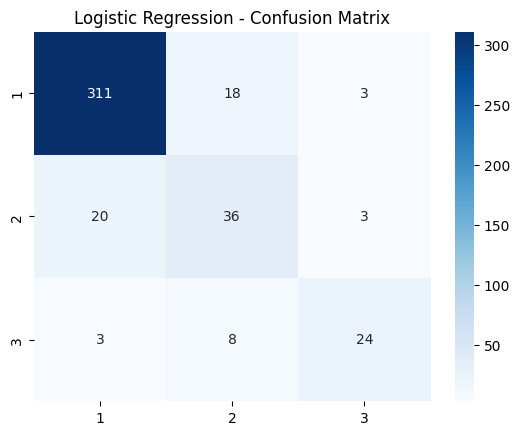


==== Linear SVM ====
Accuracy: 0.892
Macro F1: 0.7917

Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       332
         2.0       0.62      0.68      0.65        59
         3.0       0.81      0.74      0.78        35

    accuracy                           0.89       426
   macro avg       0.80      0.79      0.79       426
weighted avg       0.89      0.89      0.89       426



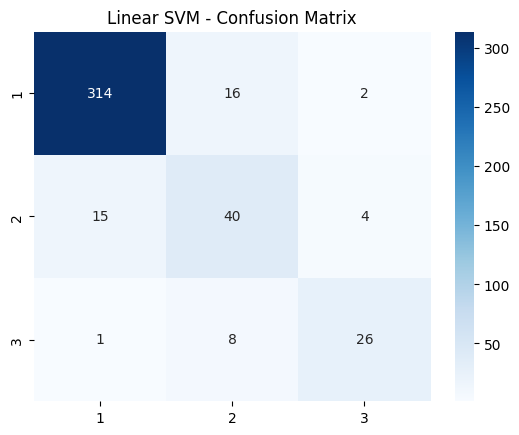


==== Random Forest ====
Accuracy: 0.9296
Macro F1: 0.8588

Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.98      0.96       332
         2.0       0.85      0.68      0.75        59
         3.0       0.86      0.86      0.86        35

    accuracy                           0.93       426
   macro avg       0.89      0.84      0.86       426
weighted avg       0.93      0.93      0.93       426



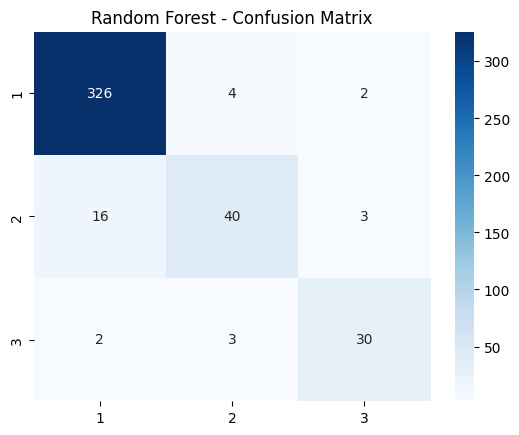


==== Extra Trees ====
Accuracy: 0.9249
Macro F1: 0.8409

Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.98      0.97       332
         2.0       0.79      0.69      0.74        59
         3.0       0.87      0.77      0.82        35

    accuracy                           0.92       426
   macro avg       0.87      0.82      0.84       426
weighted avg       0.92      0.92      0.92       426



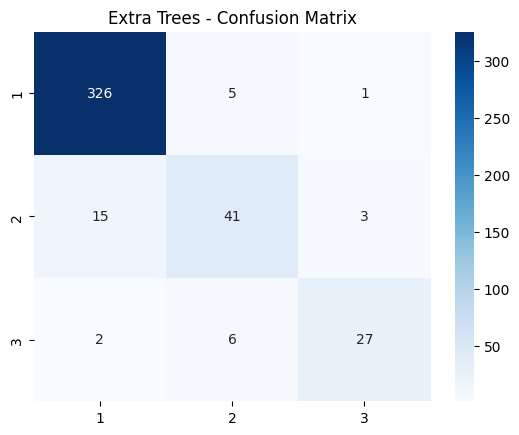

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

==== LightGBM ====
Accuracy: 0.9484
Macro F1: 0.8984

Classification Report:
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97       332
         2.0       0.87      0.80      0.83        59
         3.0       0.86      0.91      0.89        35

    accuracy                           0.95       426
   macro avg       0.90      0.90      0.90       

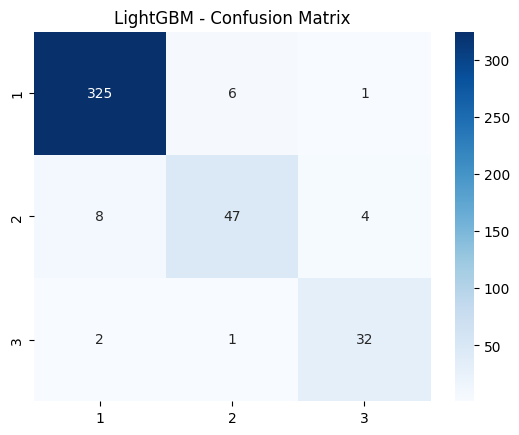


==== XGBoost ====
Accuracy: 0.9531
Macro F1: 0.9128

Classification Report:
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97       332
         2.0       0.89      0.81      0.85        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.95       426
   macro avg       0.92      0.90      0.91       426
weighted avg       0.95      0.95      0.95       426



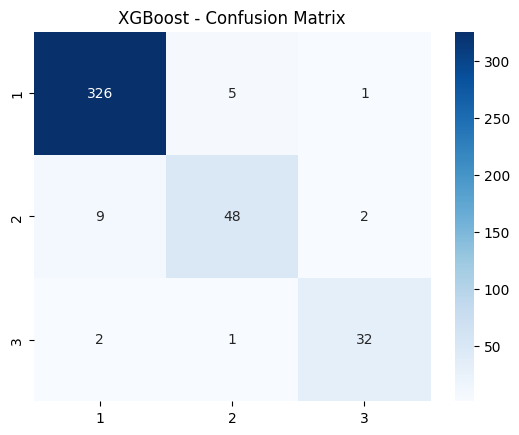


==== CatBoost ====
Accuracy: 0.9343
Macro F1: 0.8786

Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.99      0.96       332
         2.0       0.91      0.66      0.76        59
         3.0       0.97      0.86      0.91        35

    accuracy                           0.93       426
   macro avg       0.94      0.84      0.88       426
weighted avg       0.93      0.93      0.93       426



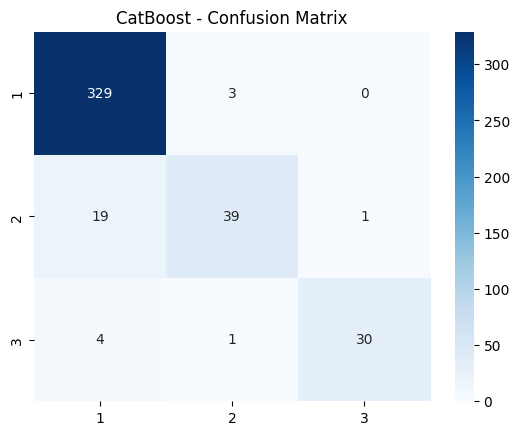


==== kNN ====
Accuracy: 0.8826
Macro F1: 0.757

Classification Report:
              precision    recall  f1-score   support

         1.0       0.92      0.97      0.94       332
         2.0       0.63      0.53      0.57        59
         3.0       0.88      0.66      0.75        35

    accuracy                           0.88       426
   macro avg       0.81      0.72      0.76       426
weighted avg       0.88      0.88      0.88       426



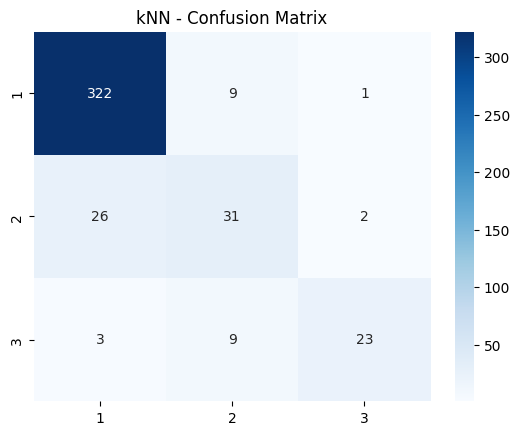


==== Naive Bayes ====
Accuracy: 0.8146
Macro F1: 0.6737

Classification Report:
              precision    recall  f1-score   support

         1.0       0.98      0.85      0.91       332
         2.0       0.46      0.81      0.59        59
         3.0       0.55      0.51      0.53        35

    accuracy                           0.81       426
   macro avg       0.66      0.72      0.67       426
weighted avg       0.87      0.81      0.83       426



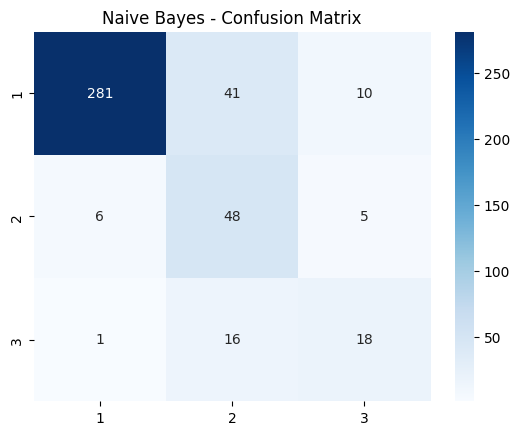


==== MLP ====
Accuracy: 0.8545
Macro F1: 0.7267

Classification Report:
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.92       332
         2.0       0.57      0.51      0.54        59
         3.0       0.70      0.74      0.72        35

    accuracy                           0.85       426
   macro avg       0.73      0.73      0.73       426
weighted avg       0.85      0.85      0.85       426



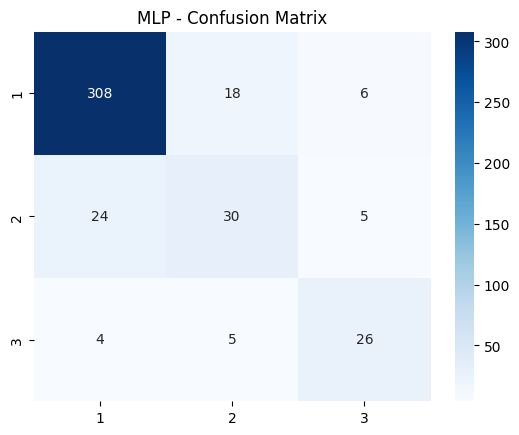

In [39]:
# 5 Store Results

results = []
best_baseline_model = None

for name, model in models.items():
    res = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(res)

In [40]:
# 6 Rank Models

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="macro_f1", ascending=False)

results_df

,model,accuracy,macro_f1
5,XGBoost,0.953052,0.912811
4,LightGBM,0.948357,0.898420
6,CatBoost,0.934272,0.878595
2,Random Forest,0.929577,0.858786
3,Extra Trees,0.924883,0.840949
1,Linear SVM,0.892019,0.791722
7,kNN,0.882629,0.757024
0,Logistic Regression,0.870892,0.755812
9,MLP,0.854460,0.726697
8,Naive Bayes,0.814554,0.673743


In [41]:
# 7 Top 3 Models

print("Top 3 Models by Macro F1:\n")
print(results_df.head(3))   

Top 3 Models by Macro F1:

      model  accuracy  macro_f1
5   XGBoost  0.953052  0.912811
4  LightGBM  0.948357  0.898420
6  CatBoost  0.934272  0.878595
